In [2]:
# Cell 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# For progress bar during tokenization
from tqdm import tqdm



In [3]:
# Load the Yelp dataset
df = pd.read_csv("yelp_restaurants_hotels_ver2.csv")

# Display basic information
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (147757, 16)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,cleaned_text,vader_sentiment,star_sentiment,sentiment_score,is_restaurant_or_hotel,business_type,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",7/7/2018 22:09,if you decide to eat here just be aware it is ...,positive,neutral,0.8491,True,restaurant,496
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2/5/2014 20:30,family diner had the buffet eclectic assortmen...,positive,neutral,0.9201,True,restaurant,323
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",1/4/2015 0:01,wow yummy different delicious our favorite is ...,positive,positive,0.9509,True,restaurant,215
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,1/14/2017 20:54,cute interior and owner gave us tour of upcomi...,positive,positive,0.9798,True,restaurant,513
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,9/23/2015 23:10,i am a long term frequent customer of this est...,positive,negative,0.5859,True,restaurant,325


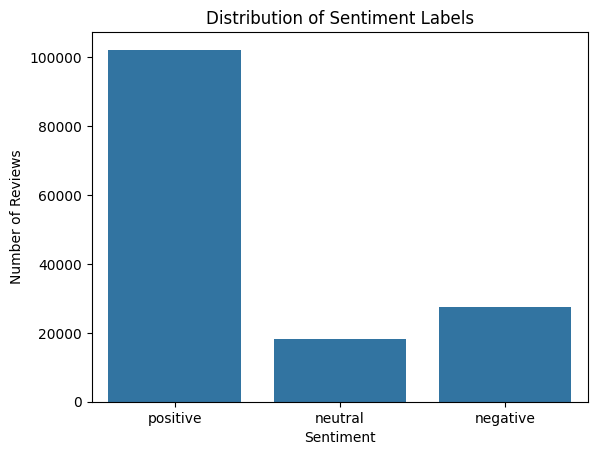

star_sentiment
positive    102220
negative     27376
neutral      18155
Name: count, dtype: int64


In [4]:
# Cell 2

# Drop rows with missing cleaned_text or sentiment label
df = df.dropna(subset=["cleaned_text", "star_sentiment"])

# Keep only reviews labeled as positive, negative, or neutral
df = df[df["star_sentiment"].isin(["positive", "negative", "neutral"])]

# Reset index
df.reset_index(drop=True, inplace=True)

# Check label distribution
sns.countplot(data=df, x="star_sentiment", order=["positive", "neutral", "negative"])
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

# Print value counts
print(df["star_sentiment"].value_counts())


In [5]:
# Cell 3

# Encode the sentiment labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["star_sentiment"])

# Display encoding mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding:", label_map)

# Split into train (80%) and temp (20%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["cleaned_text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

# Split temp into val (10%) and test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Confirm sizes
print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")


Label Encoding: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Train size: 118200
Validation size: 14775
Test size: 14776


In [6]:
# Cell 4

from transformers import DistilBertTokenizerFast

# Load pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize all datasets
def tokenize_data(texts, labels, max_len=256):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    ), np.array(labels)

# Tokenize train, validation, and test sets
train_encodings, train_labels = tokenize_data(train_texts, train_labels)
val_encodings, val_labels = tokenize_data(val_texts, val_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

print("Tokenization complete.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenization complete.


In [7]:
# Cell 5

import torch
from torch.utils.data import Dataset

class YelpSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Wrap datasets
train_dataset = YelpSentimentDataset(train_encodings, train_labels)
val_dataset = YelpSentimentDataset(val_encodings, val_labels)
test_dataset = YelpSentimentDataset(test_encodings, test_labels)

print("PyTorch datasets ready.")


PyTorch datasets ready.


In [8]:
# Cell 6

from torch.utils.data import DataLoader

# Set batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("DataLoaders are ready!")


DataLoaders are ready!


In [9]:
# Cell 7

from transformers import DistilBertForSequenceClassification

# Load pre-trained DistilBERT model with a classification head for 3 classes
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # For positive, neutral, negative
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded on {device}.")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda.


In [10]:
# Cell 8

from transformers import get_scheduler
from torch.optim import AdamW

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Define learning rate scheduler
num_epochs = 3
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Define evaluation metric function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return acc, precision, recall, f1

In [11]:
# Cell 9

from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to tensor and move to the same device as model
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights_tensor)

# Define weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


Class Weights: tensor([1.7990, 2.7128, 0.4818], device='cuda:0')


In [12]:
# Cell 10

from tqdm import tqdm

best_f1 = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # --- Training ---
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        all_preds.extend(logits.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc, train_prec, train_rec, train_f1 = compute_metrics(all_preds, all_labels)
    print(f"Train Loss: {total_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")

    # --- Validation ---
    model.eval()
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            val_preds.extend(logits.detach().cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_acc, val_prec, val_rec, val_f1 = compute_metrics(val_preds, val_labels_list)
    print(f"Val Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_distilbert_model.pt")
        best_f1 = val_f1
        print("Best model saved!")




Epoch 1/3


100%|██████████| 7388/7388 [42:43<00:00,  2.88it/s]


Train Loss: 3905.3538 | Acc: 0.8173 | Prec: 0.8619 | Rec: 0.8173 | F1: 0.8338
Val Acc: 0.8543 | Prec: 0.8828 | Rec: 0.8543 | F1: 0.8650
Best model saved!

Epoch 2/3


100%|██████████| 7388/7388 [42:47<00:00,  2.88it/s]


Train Loss: 2866.5310 | Acc: 0.8687 | Prec: 0.9003 | Rec: 0.8687 | F1: 0.8797
Val Acc: 0.8631 | Prec: 0.8889 | Rec: 0.8631 | F1: 0.8726
Best model saved!

Epoch 3/3


100%|██████████| 7388/7388 [42:48<00:00,  2.88it/s]


Train Loss: 1762.2487 | Acc: 0.9179 | Prec: 0.9355 | Rec: 0.9179 | F1: 0.9233
Val Acc: 0.8635 | Prec: 0.8852 | Rec: 0.8635 | F1: 0.8719


              precision    recall  f1-score   support

    negative       0.88      0.81      0.84      2738
     neutral       0.48      0.68      0.56      1815
    positive       0.96      0.91      0.93     10223

    accuracy                           0.86     14776
   macro avg       0.77      0.80      0.78     14776
weighted avg       0.89      0.86      0.87     14776



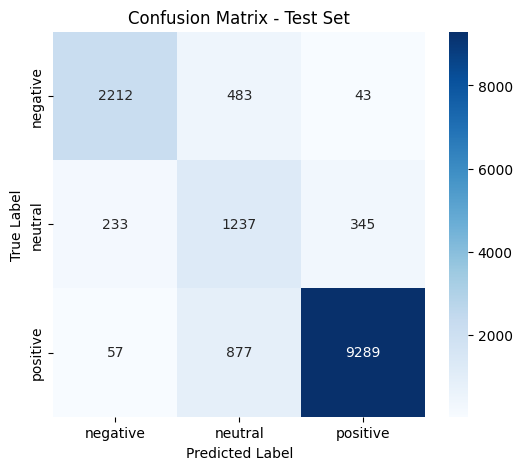

In [13]:
# Cell 11

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best saved model (from training loop)
model.load_state_dict(torch.load("best_distilbert_model.pt"))
model.eval()

# Predict on test set
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        test_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        test_true.extend(labels.cpu().numpy())

# Classification report
print(classification_report(test_true, test_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()
